# Предсказание Погоды
## Временные последовательности. Рекуррентные нейронные сети.

Используются временные последовательности данных о погоде, записанных на гидрометерологической станции в Институте биогеохимии Макса Планка в Йене, Германия. В набор данных включены замеры 14 разных характеристик(таких как температура, влажность и другие), выполнявшиеся каждые 10 минут в течение нескольких лет.

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-06-16 17:11:46--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.207.69, 54.231.226.104, 52.217.166.40, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.207.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.0MB/s    in 0.7s    

2025-06-16 17:11:47 (19.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [44]:
from matplotlib import pyplot as plt

from tensorflow import keras
import tensorflow as tf



Обзор набора метеорологических данных Jena.

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))



['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Преобразуем строки с данными в массивы Numpy: один для температуры, а другой для остальных данных - признаков, которые будут использоваться для прогнозирования температуры в будущем.

In [ ]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, lines in enumerate(lines):
  values = [float(x) for x in lines.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i,:] = values[:]

График изменения температуры, построенный по полному набору данных.

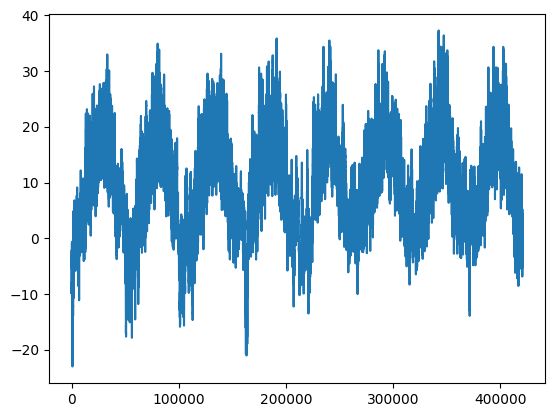

In [ ]:
plt.plot(range(len(temperature)), temperature)

График изменения температуры по данным за первые десять дней.

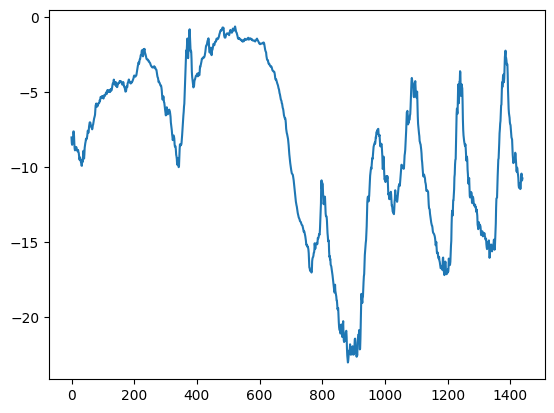

In [ ]:
plt.plot(range(1440), temperature[:1440])

# Подготовка данных

Вычисление количества образцов в каждой выборке.

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples: ", num_train_samples)
print("num_val_samples: ", num_val_samples)
print("num_test_samples: ", num_test_samples)

num_train_samples:  210225
num_val_samples:  105112
num_test_samples:  105114


Нормализация данных. Данные представлены в числовом виде, но временные последовательности разных параметров имеют разный масштаб.

In [ ]:
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

In [45]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples

)

In [46]:
for samples, targets in train_dataset:
  print("samples shape: ", samples.shape)
  print("targets shape: ", targets.shape)
  break

samples shape:  (256, 120, 14)
targets shape:  (256,)


## Наивное решение.

В данном случае временные последовательности можно считать монотонными, а также подчиняющиеся суточной периодичности.

In [47]:
def evaluate_naive_method(dataset):

  total_abs_err = 0
  samples_seen = 0
  for samples , targets in dataset:
    preds = samples[:,-1,1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Valudation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Valudation MAE: 2.44
Test MAE: 2.62


Это базовое решение обеспечивает среднюю ошибку в 2.44 градуса Цельсия на проверочных данных и 2.62 градуса Цельсия - на контрольных данных.

## Одномерная свёрточная сеть.

In [48]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 109ms/step - loss: 31.0124 - mae: 4.3087 - val_loss: 16.2543 - val_mae: 3.1674
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - loss: 16.7906 - mae: 3.2653 - val_loss: 14.8837 - val_mae: 3.0432
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - loss: 15.3305 - mae: 3.1198 - val_loss: 14.5454 - val_mae: 3.0093
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 14.3842 - mae: 3.0134 - val_loss: 21.8161 - val_mae: 3.7387
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 109ms/step - loss: 13.6451 - mae: 2.9269 - val_loss: 14.8060 - val_mae: 3.0310
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 114ms/step - loss: 12.9835 - mae: 2.8499 - val_loss: 14.4810 - val_mae: 2.9855
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 109ms/step - loss: 12.4760 - mae: 2.7913 - val_loss: 14.3894 - val_mae: 2.9783
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 136s 102ms/step - loss: 12.1196 - mae: 2.7458 - val_loss: 14.4371 - val_mae: 2.9766
Epoch 9/10
819

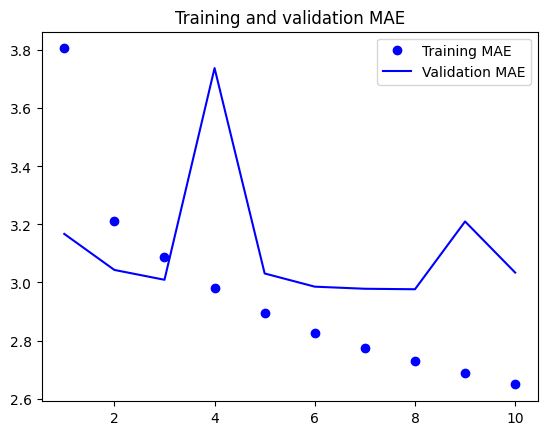

In [49]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Данная моделб прогнозирует температуру хуже, чем полносвязная.

- Во-первых, данные о погоде не соотвествуют предположению о инвариантности в отношении переноса. Несмотря на наличие суточных циклов в данных, утренние данные обладают иными свойствами, чем вечерние или ночные. Данные о погоде являются инвариантными в отношении переноса только для очень конкретной временной шкалы.

- Во-вторых, порядок в данных о погоде имеет большое значение. Недавнее прошлое гораздо информативнее для предсказания температуры следующего дня, чем данные пятидневной давности. В частности, слои MaxPooling1D и GlobalAveragePooling1D уничтожают информацию о порядке.

In [50]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 127s 152ms/step - loss: 77.5191 - mae: 6.7594 - val_loss: 13.2604 - val_mae: 2.7500
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 104s 126ms/step - loss: 12.3964 - mae: 2.7102 - val_loss: 9.4509 - val_mae: 2.3873
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 106s 130ms/step - loss: 10.0451 - mae: 2.4659 - val_loss: 9.4728 - val_mae: 2.3938
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 106s 129ms/step - loss: 9.5560 - mae: 2.4001 - val_loss: 9.3391 - val_mae: 2.3823
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 105s 127ms/step - loss: 9.1957 - mae: 2.3540 - val_loss: 9.4206 - val_mae: 2.3858
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 106s 130ms/step - loss: 8.9011 - mae: 2.3161 - val_loss: 9.5102 - val_mae: 2.3960
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 159s 151ms/step - loss: 8.6601 - mae: 2.2876 - val_loss: 9.3310 - val_mae: 2.3731
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 127s 133ms/step - loss: 8.4763 - mae: 2.2623 - val_loss: 9.3498 - val_mae: 2.3811
Epoch 9/10
819/819 ━

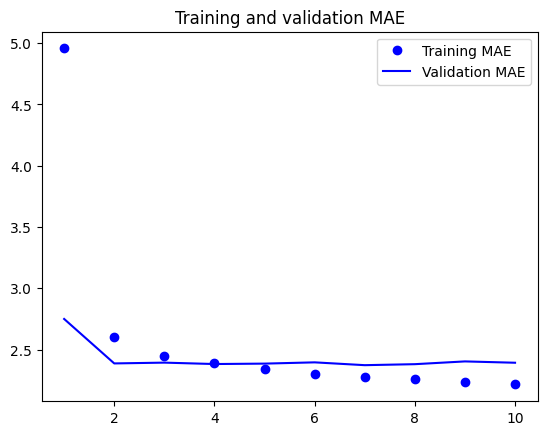

In [51]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Модель LSTM показала заметно лучший результат, чем полносвязная и сверточная модель.